# Promolecular properties: water dimer

The `promolecule` module in QC-AtomDB constructs approximate molecular (promolecular) properties as linear combinations  of atomic properties. This allows for the fast calculation of the reduced density gradient for large molecular systems. The following examples show how to calculate several molecular properties. As model systems the water molecule dimer will be used:

<img src="images/h2o_dimer.png" alt="drawing" style="width: 300px;"/>

## Loading the water dimer data:

The following code loads geometry data for the water dimer. The [qc-iodata](https://iodata.readthedocs.io/en/latest/index.html) package is used to read the data from a file.


In [1]:
import atomdb
import iodata
import numpy as np
from importlib_resources import files

# Load the H2O dimer from a .xyz file
data_file=files(atomdb).joinpath('../docs/notebooks/data/h2o_dimer.xyz')
mol_data = iodata.load_one(data_file)

atnums = mol_data.atcorenums
atcoords = mol_data.atcoords

atnums_mono = np.array([atnums[0], atnums[2], atnums[3]])
atcoords_mono = np.array([atcoords[0], atcoords[2], atcoords[3]])

print("Atomic numbers dimer:\n", atnums)
print("Atomic coordinates dimer:\n", atcoords)

print("Atomic numbers monomer:\n", atnums_mono)
print("Atomic coordinates monomer:\n", atcoords_mono)



Atomic numbers dimer:
 [8. 8. 1. 1. 1. 1.]
Atomic coordinates dimer:
 [[-3.18178101e-03  2.86604567e+00  0.00000000e+00]
 [-3.18178101e-03 -2.63385134e+00  0.00000000e+00]
 [-1.56049721e-01  1.05094178e+00  0.00000000e+00]
 [-1.71174798e+00  3.45941149e+00  0.00000000e+00]
 [ 9.59353124e-01 -3.18395394e+00  1.43347310e+00]
 [ 9.59353124e-01 -3.18395394e+00 -1.43347310e+00]]
Atomic numbers monomer:
 [8. 1. 1.]
Atomic coordinates monomer:
 [[-3.18178101e-03  2.86604567e+00  0.00000000e+00]
 [-1.56049721e-01  1.05094178e+00  0.00000000e+00]
 [-1.71174798e+00  3.45941149e+00  0.00000000e+00]]


## Define grid for computing the properties:

The following code defines a uniform grid of points where the properties will be computed. The grid is defined using the [qc-grid](https://grid.qcdevs.org/) package for numerical integration.

In [2]:
import grid

# Generate a 3D grid with a spacing of 0.2 Bohr and an extension of 5.0 Bohr
cubgrid = grid.UniformGrid.from_molecule(atnums, atcoords, spacing=0.2, extension=5.0, rotate=False)

print("Grid origin:", cubgrid.origin)
print("Number of grid points:", len(cubgrid.points))

Grid origin: [-6.4 -8.4 -6.5]
Number of grid points: 349440


## Create the promolecular object and compute the properties on the grid:

The following code creates a `promolecule` object. The object is used to compute the promolecular properties on the grid.

In [3]:
import numpy as np

dimer_promol = atomdb.make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')
mono_promol = atomdb.make_promolecule(atnums=atnums_mono, coords=atcoords_mono, dataset='slater')

# compute the density and gradient of the density at the grid points
dimer_rho = dimer_promol.density(cubgrid.points, log=True)
dimer_grad_rho = dimer_promol.gradient(cubgrid.points)

# compute the density and gradient of the density at the monomer grid points
mono_rho = mono_promol.density(cubgrid.points, log=True)
mono_grad_rho = mono_promol.gradient(cubgrid.points)

print("Water dimer:")
print(f"Max density: {dimer_rho.max()} at point {cubgrid.points[dimer_rho.argmax()]}")
print(f"Min density: {dimer_rho.min()} at point {cubgrid.points[dimer_rho.argmin()]}")
max_grad_idx = np.linalg.norm(dimer_grad_rho, axis=1).argmax()
print(f"Max gradient: {dimer_grad_rho[max_grad_idx]} at {cubgrid.points[max_grad_idx]}")

print("\nWater monomer:")
print(f"Max density: {mono_rho.max()} at point {cubgrid.points[mono_rho.argmax()]}")
print(f"Min density: {mono_rho.min()} at point {cubgrid.points[mono_rho.argmin()]}")
max_grad_idx = np.linalg.norm(mono_grad_rho, axis=1).argmax()
print(f"Max gradient: {mono_grad_rho[max_grad_idx]} at {cubgrid.points[max_grad_idx]}")

Water dimer:
Max density: 58.822613951764545 at point [ 2.54168153e-09 -2.60000000e+00 -1.00000000e-01]
Min density: 1.2377283201197663e-10 at point [ 6.2  8.2 -6.5]
Max gradient: [ -27.52964686 -293.09156189  865.78533133] at [ 2.54168153e-09 -2.60000000e+00 -1.00000000e-01]

Water monomer:
Max density: 47.15235612981739 at point [ 2.54168153e-09  2.80000000e+00 -1.00000000e-01]
Min density: 1.310490950417405e-12 at point [ 6.2 -8.4 -6.5]
Max gradient: [-19.37085558 401.7291462  608.28125388] at [ 2.54168153e-09  2.80000000e+00 -1.00000000e-01]


## Compute reduced density gradient:

The [reduced density gradient](https://pubs.acs.org/doi/10.1021/ct100641a) is defined as:

\begin{equation*}
s(\mathbf{r}) = \frac{1}{2(3\pi^2)^{1/3}}\frac{|\nabla \rho (\mathbf{r})|}{\rho^{4/3}(\mathbf{r})}
\end{equation*}

The following code computes the reduced density gradient on the grid from the estimated promolecular properties (electron density and gradient of the electron density).

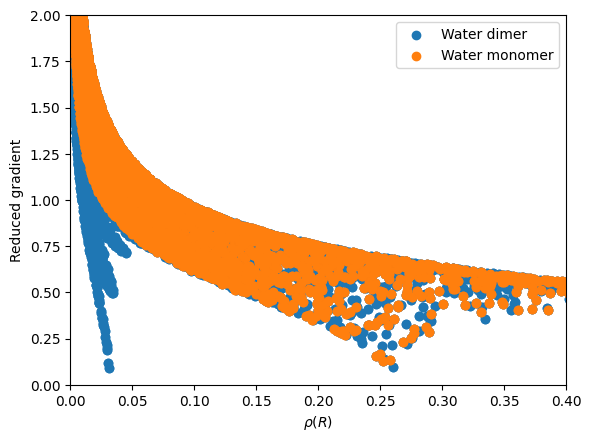

In [4]:
import matplotlib.pyplot as plt

# compute the reduced density gradient for the dimer
coeff = 2 * (3 * np.pi ** 2) ** (1 / 3)
dimer_grad_norm = np.linalg.norm(dimer_grad_rho, axis=1)
dimer_rdg = dimer_grad_norm / (coeff * dimer_rho ** (4 / 3))

# compute the reduced density gradient for the monomer
mono_grad_norm = np.linalg.norm(mono_grad_rho, axis=1)
mono_rdg = mono_grad_norm / (coeff * mono_rho ** (4 / 3))

import matplotlib.pyplot as plt

# Plot the reduced gradient as a function of the density
plt.scatter(dimer_rho, dimer_rdg, label='Water dimer')
plt.scatter(mono_rho, mono_rdg, label='Water monomer')
plt.xlabel(r'$\rho(R)$')
plt.ylabel(r'Reduced gradient')

# Set y-axis limits from 0 to 1
plt.ylim(0, 2)
plt.xlim(0, 0.4)

# Add a legend
plt.legend()

plt.show()